In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\down\\a996cf66_nohash_0.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [10]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

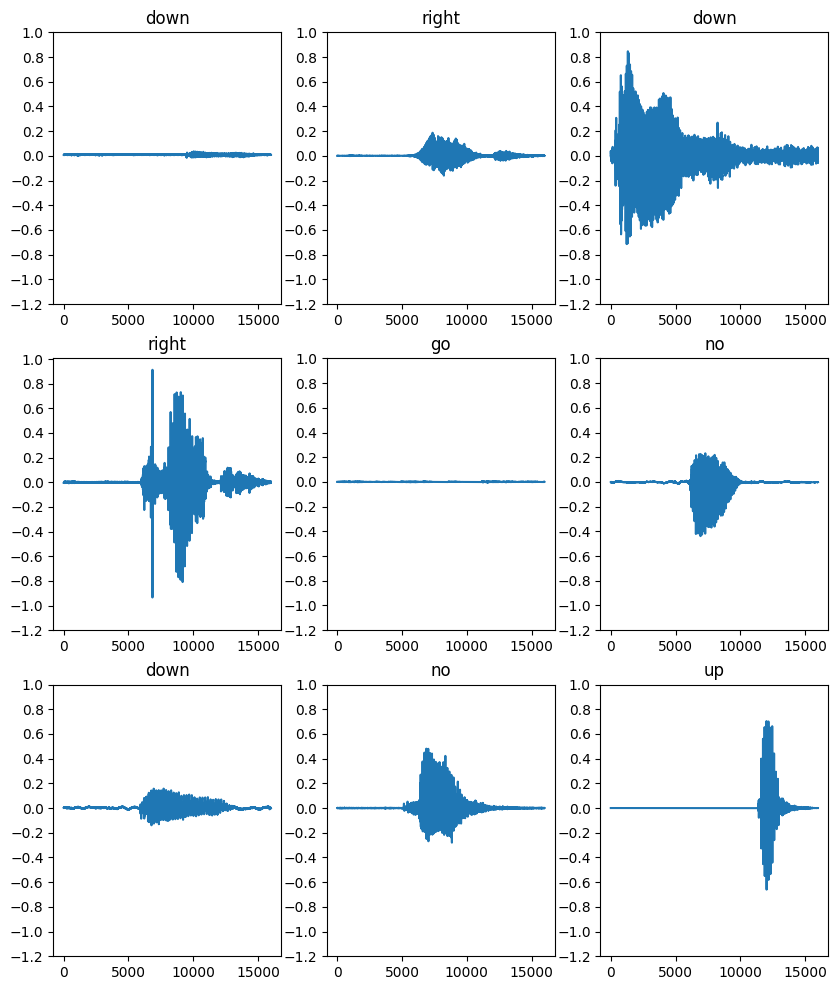

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [14]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

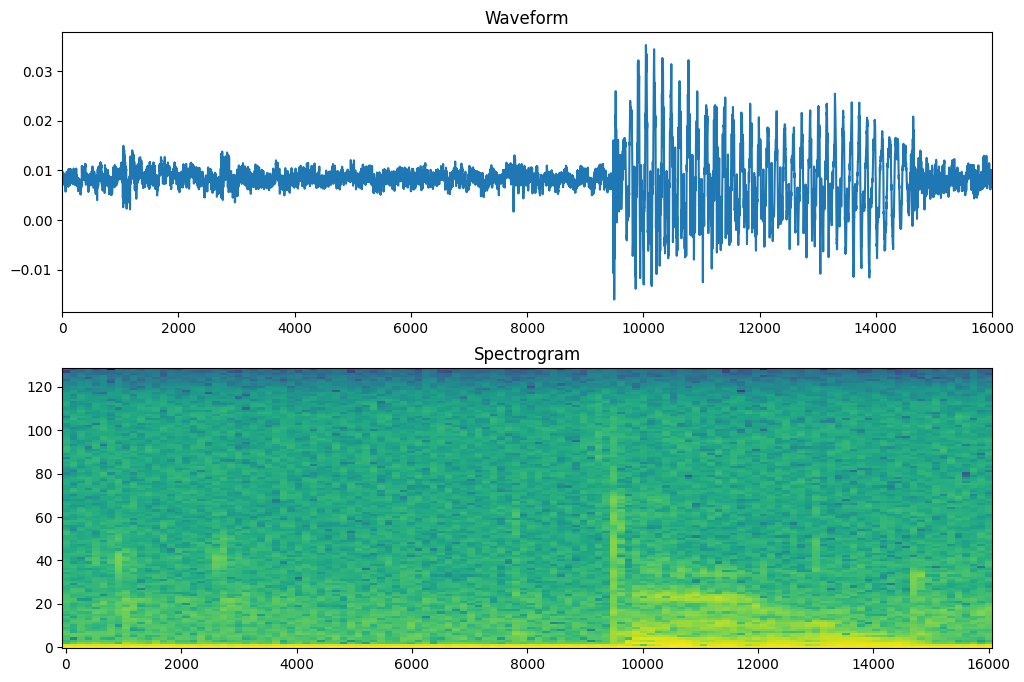

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [18]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

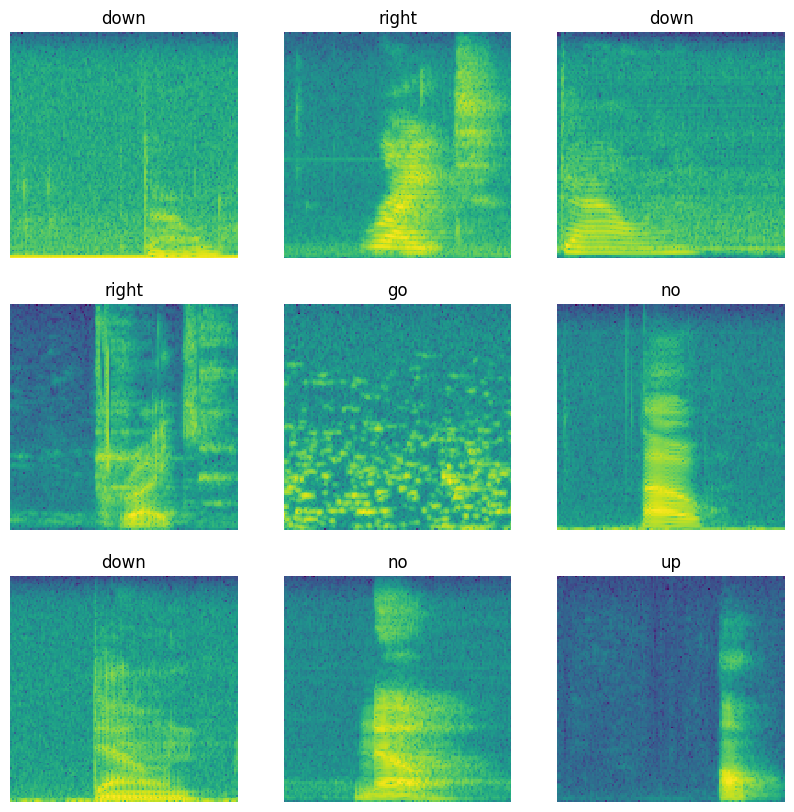

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [33]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
'''
model = models.Sequential([
    # 1st layer - Image input layer to adjust image dimensions by number of hops and number of bands
    layers.Input(shape=input_shape),
    
    # 2nd layer - To add filter size of pixels (padding equal 3)
    layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu'),
    
    # 3rd layer - Normalization with ReLU
    layers.BatchNormalization(),
    layers.ReLU(),
    
    # 4th layer - Add pooling to reduce size with 3 stride and 2 padding
    layers.MaxPooling2D(pool_size=(2, 2), strides=3, padding='same'),
    
    # 5th layer - Assuming doubling the number of filters for padding
    layers.Conv2D(20, (3, 3), padding='same', activation='relu'),
    
    # 6th layer - Batch normalization with ReLU and maxpooling2dlayer with stride 3 and padding 2
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=3, padding='same'),
    
    # 7th layer - Convolution 2D Layer
    layers.Conv2D(30, (3, 3), padding='same', activation='relu'),
    
    # 8th layer - Batch Normalization Layer (ReLU layer)
    layers.BatchNormalization(),
    layers.ReLU(),
    
    # 9th layer - Max Pooling 2D Layer
    layers.MaxPooling2D(pool_size=(2, 2), padding='valid'),  # Assuming timePoolSize refers to a 2x2 pool size
    
    # 10th layer - Dropout Layer
    layers.Dropout(0.5),
    
    # 11th layer - Fully Connected Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Assuming 128 units for the dense layer
    
    # 12th layer - Softmax Layer
    layers.Dense(num_classes, activation='softmax'),
    
    # 13th layer - Classification Layer is implicit after softmax in Keras
])
'''

Input shape: (124, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

"\nmodel = models.Sequential([\n    # 1st layer - Image input layer to adjust image dimensions by number of hops and number of bands\n    layers.Input(shape=input_shape),\n    \n    # 2nd layer - To add filter size of pixels (padding equal 3)\n    layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu'),\n    \n    # 3rd layer - Normalization with ReLU\n    layers.BatchNormalization(),\n    layers.ReLU(),\n    \n    # 4th layer - Add pooling to reduce size with 3 stride and 2 padding\n    layers.MaxPooling2D(pool_size=(2, 2), strides=3, padding='same'),\n    \n    # 5th layer - Assuming doubling the number of filters for padding\n    layers.Conv2D(20, (3, 3), padding='same', activation='relu'),\n    \n    # 6th layer - Batch normalization with ReLU and maxpooling2dlayer with stride 3 and padding 2\n    layers.BatchNormalization(),\n    layers.ReLU(),\n    layers.MaxPooling2D(pool_size=(2, 2), strides=3, padding='same'),\n    \n    # 7th layer - Convolution 2D La

In [34]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
    )

In [35]:
EPOCHS = 150
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2744 - loss: 1.9386 - val_accuracy: 0.5550 - val_loss: 1.3199
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5484 - loss: 1.2769 - val_accuracy: 0.6725 - val_loss: 0.9529
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6685 - loss: 0.9452 - val_accuracy: 0.7163 - val_loss: 0.7760
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7341 - loss: 0.7640 - val_accuracy: 0.7875 - val_loss: 0.6735
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7824 - loss: 0.6265 - val_accuracy: 0.7887 - val_loss: 0.5950
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8153 - loss: 0.5380 - val_accuracy: 0.7937 - val_loss: 0.5782
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8350 - loss: 0.4847 - val_accuracy: 0.8087 - val_loss: 0.5715
Epoch 8/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8402 - loss: 0.4458 - 

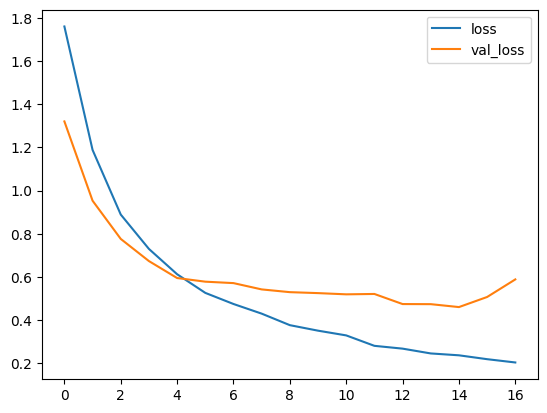

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [53]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [54]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test set accuracy: 83%


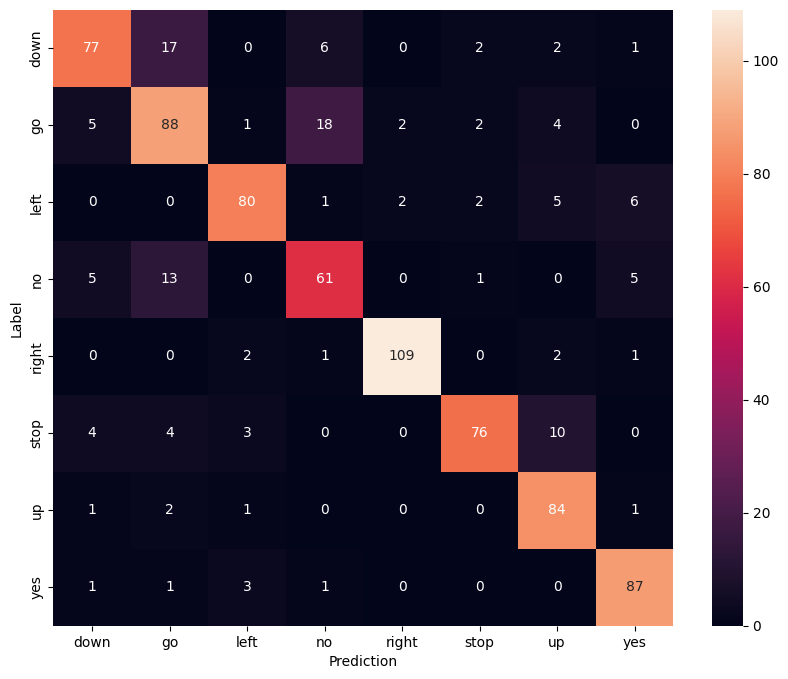

In [55]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

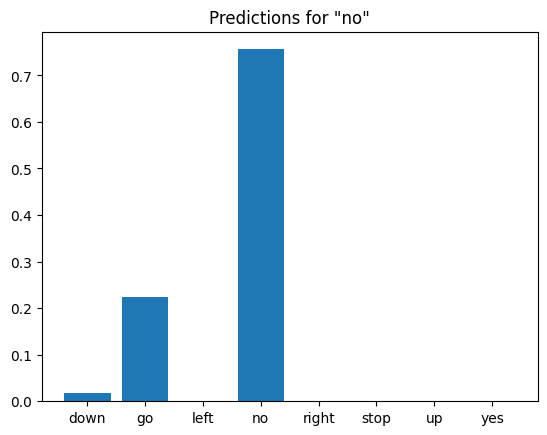

In [56]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

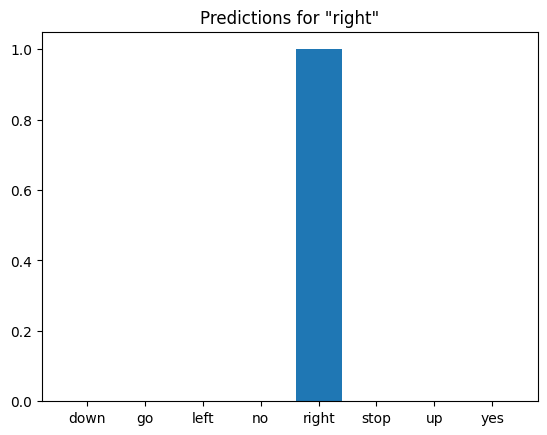

In [57]:
sample_file = data_dir/'right/012c8314_nohash_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [98]:
tf.saved_model.save(model, "Last_model")

INFO:tensorflow:Assets written to: Last_model\assets


INFO:tensorflow:Assets written to: Last_model\assets


In [87]:
imported_model = tf.saved_model.load("saved_model")

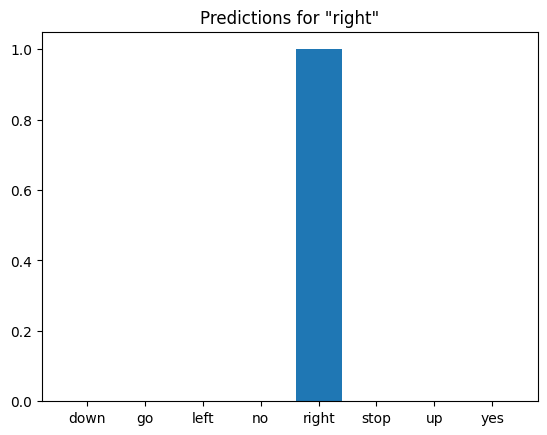

In [99]:
# Assuming sample_ds is your dataset
for spectrogram, label in sample_ds.batch(1):
    # Get predictions using the serving_default signature
    predictions = imported_model.signatures["serving_default"](spectrogram)
    
    # Access the prediction tensor by its name
    prediction_tensor = predictions["output_0"]
    
    # Perform any necessary postprocessing on the prediction tensor
    probabilities = tf.nn.softmax(prediction_tensor[0])
    
    # Plot the probabilities
    plt.bar(commands, probabilities)
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

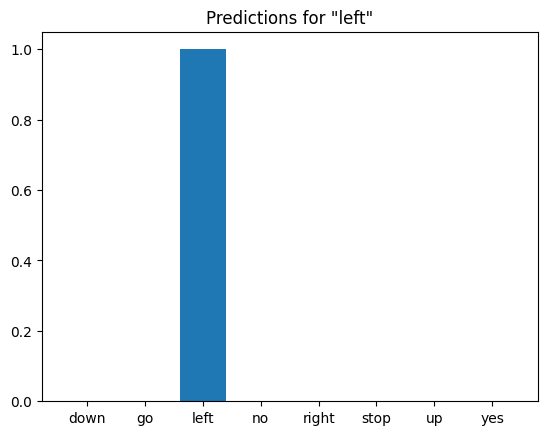

In [103]:
sample_file = data_dir/'left/7cbf645a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])
# Assuming sample_ds is your dataset
for spectrogram, label in sample_ds.batch(1):
    # Get predictions using the serving_default signature
    predictions = imported_model.signatures["serving_default"](spectrogram)
    
    # Access the prediction tensor by its name
    prediction_tensor = predictions["output_0"]
    
    # Perform any necessary postprocessing on the prediction tensor
    probabilities = tf.nn.softmax(prediction_tensor[0])
    
    # Plot the probabilities
    plt.bar(commands, probabilities)
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

In [104]:
commands

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U9')

In [90]:
import wave
obj = wave.open(str(sample_file),'rb')
n_samples = obj.getnframes()
signal_wave = obj.readframes(n_samples)
singnal_array=np.frombuffer(signal_wave,dtype=np.int16)
obj.close()

print(singnal_array.shape)

(16000,)


In [97]:
waveform = singnal_array / 32768
waveform = tf.convert_to_tensor(waveform,dtype=tf.float32)
spec = get_spectrogram(waveform)
spec = tf.expand_dims(spec,0)
prediction =  imported_model.signatures["serving_default"](spec)
print(prediction)

{'output_0': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-4.8044834, -1.6222006,  2.38042  , -4.3091307, 11.238915 ,
        -5.2736764, -3.510221 , -2.9370985]], dtype=float32)>}
